# LangGraph simple Graph - Python Cookbook

## Terminology

| Term  | Traditional Graph | LangGraph |
|:-----------------------|:---------------------|:---------------------|
| State | The current configuration of the graph. | Config/ state as a dict |
| Node  | A fundamental part of the graph representing an entity. | A python function entitled to modify/ manage the state |
| Edge  | A connection between two nodes in the graph. | Conditionals for connecting nodes |

### State

In [18]:
from pydantic import BaseModel, field_validator, ValidationError, ValidationInfo
from typing import Literal, TypeVar

Unit = TypeVar('Unit', bound=Literal['C', 'F'])

class WeatherState(BaseModel):
	temperature: int
	unit: Unit | None = None
	weather_summary: str | None = None

	@field_validator('temperature')
	@classmethod
	def validate_temperature(cls, value: int | None, values: ValidationInfo):
		unit = values.data.get('unit')
		if unit == 'C' and (value < -30 or value > 50):
			raise ValidationError('Temperature in Celsius must be between -30 and 50')
		elif unit == 'F' and (value < -22 or value > 122):
			raise ValidationError('Temperature in Fahrenheit must be between -22 and 122')
		return value
	
	@field_validator('unit')
	@classmethod
	def validate_unit(cls, value: Unit | None):
		if value is not None and value not in ['C', 'F']:
			raise ValidationError('Unit must be either C or F')
		return value
	

	@field_validator('weather_summary')
	@classmethod
	def validate_weather_summary(cls, value: str | None):
		if value is not None:
			raise ValidationError('Weather summary must not be empty')
		return value

### Nodes

In [19]:
def node1(state: WeatherState) -> WeatherState:
	"""Update the temperature according to the location."""
	# For simplicity, let's assume the temperature is always 30 degrees. In a real application, this could be fetched from an API based on the location.
	return state

def node2(state: WeatherState) -> WeatherState:
	"""Update the temperature unit to Celsius if outside USA."""
	#In a real application, this could be fetched from user preferences or settings.
	state.unit = 'C'
	verdict = "It's a hot day! 🥵" if state.temperature > 30 else "It's a pleasant day!🌞"
	state.weather_summary = f"{state.temperature} degrees Celsius. {verdict}"
	return state

def node3(state: WeatherState) -> WeatherState:
	"""Update the temperature unit to Fahrenheit if in USA."""
	#In a real application, this could be fetched from user preferences or settings.
	state.unit = 'F'
	verdict = "It's a hot day! 🥵" if state.temperature > 85 else "It's a pleasant day!🌞"
	state.weather_summary = f"{state.temperature} degrees Fahrenheit. {verdict}"
	return state

### Edge

In [20]:
import random

from typing import Literal

def decide_weather_unit(state: WeatherState) -> Literal['node2', 'node3']:
	"""Decide the weather unit based on the location."""
	unit = state.unit or random.choice(['C', 'F'])
	# For simplicity, let's assume a random decision. In a real application, this could be based on user preferences or settings.
	return 'node2' if unit == 'C' else 'node3'



### Build Graph

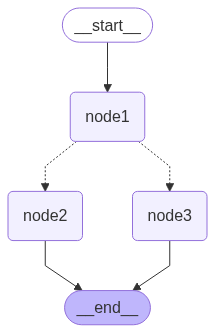

In [21]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(WeatherState)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

# Logic
builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_weather_unit, {
		'node2': "node2",
		'node3': "node3"
	})
builder.add_edge("node2", END)
builder.add_edge("node3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke Graph

In [29]:
graph.invoke(WeatherState(
	temperature=90,
))

{'temperature': 90,
 'unit': 'F',
 'weather_summary': "90 degrees Fahrenheit. It's a hot day! 🥵"}